# legi: 20-945-796

# SLT-CE-2: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT Tutorial 3 on Sampling](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial03-sampling.pdf)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [3]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [4]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

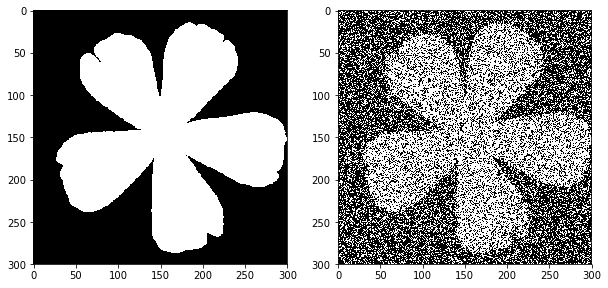

In [5]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**:
   1. Define $\{q(\cdot|c)\}_{c \in C}$ s.t. $G_q$ is connected and $q(c|c)>0$ $, \forall c\in C$ 
   2. Algorithm:<br>
   $c_0$ $\leftarrow$ (assign arbitrary/random element)<br>
   for t=1,2,...<br>
   >$\overline{c}$ $\leftarrow$ q($\cdot$|$c_{t-1}$)<br>
   >b $\leftarrow$ Bern(min{1, $\frac{f(\overline{c}))}{f(c_{t-1}))}$})<br>
   >if b=1 then $c_t$ $\leftarrow$ $\overline{c}$ else $c_t$ $\leftarrow$ $c_{t-1}$<br>
   
   Notice that in the Metropolis version of the algorithm q(c'|c) = q(c|c') $\forall$ c,c' $\in $C. Hence, the fraction can be simplified and only the function f remains.

- **Metropolis-Hastings**: 
   1. Define $\{q(\cdot|c)\}_{c \in C}$ s.t. $G_q$ is connected and $q(c|c)>0$ $, \forall c\in C$ 
   2. Algorithm:<br>
   $c_0$ $\leftarrow$ (assign arbitrary/random element)<br>
   for t=1,2,...<br>
   >$\overline{c}$ $\leftarrow$ q($\cdot$|$c_{t-1}$)<br>
   >b $\leftarrow$ Bern(min{1, $\frac{q(c_{t-1}|\overline{c})f(\overline{c}))}{q(\overline{c}|c_{t-1})f(c_{t-1}))}$})<br>
   >if b=1 then $c_t$ $\leftarrow$ $\overline{c}$ else $c_t$ $\leftarrow$ $c_{t-1}$<br>

- **Simulated Annealing**:
   0. Let $\varepsilon$ >0 a temperature threshold, reduce() a function for decreasing the temperature, and N the number of draws before decreasing the temperature
   1. Define $\{q(\cdot|c)\}_{c \in C}$ s.t. $G_q$ is connected and $q(c|c)>0$ $, \forall c\in C$ 
   2. Algorithm:<br>
   T $\leftarrow$ $\overline{T}$ sufficiently large value<br>
   $c_0$ $\leftarrow$ (assign arbitrary/random element)<br>
   while T>$\varepsilon$ do
   >for t=1,...,N<br>
   >>$\overline{c}$ $\leftarrow$ q($\cdot$|$c_{t-1}$)<br>
   >>b $\leftarrow$ Bern(min{1, $\frac{q(c_{t-1}|\overline{c})f(\overline{c}))}{q(\overline{c}|c_{t-1})f(c_{t-1}))}$})<br>
   >>if b=1 then $c_t$ $\leftarrow$ $\overline{c}$ else $c_t$ $\leftarrow$ $c_{t-1}$<br>
   
   >T $\leftarrow$ reduce(T)
   
   Where we have considered the general case with the Metropolis-Hastings acceptance probability.

<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [237]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    for i in range(height):
        for j in range(width):
            #sum within the second term of the energy E
            E2 = img_estimate[i][j]*img_noisy_observation[i][j]
            
            N = 4
            #sum over neighbours
            N_sum = 0
            if (i-1 >= 0): N_sum += img_estimate[i-1][j]
            if (j-1 >= 0): N_sum += img_estimate[i][j-1]
            if (i+1 < height): N_sum += img_estimate[i+1][j]
            if (j+1 < width): N_sum += img_estimate[i][j+1]
            E1 = (img_estimate[i][j]/N)*N_sum
            
            
            E -= (beta/2)*E1 + mu*E2
            
    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [463]:
assert np.isclose(energy(*flower()), -145700.75)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [241]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            
            #measure initial energy
            energy_init = energy(noisy_img, estimate)
            
            #attempt flip
            temp_estimate = estimate.copy()
            i = idx//width
            j = idx%width
            temp_estimate[i][j] = -temp_estimate[i][j] 
            
            #compare energies before and after flip
            energy_after_flip = energy(noisy_img, temp_estimate)
            fraction = np.exp((1/T)*(energy_init - energy_after_flip))
            acc_prob = min(1, fraction)
            accept = np.random.binomial(1,acc_prob,1)
            if (accept==1):
                estimate = temp_estimate.copy()
    
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)



<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [242]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.1353352832366127f epoch 1
0.1353352832366127f epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
1inished   0.98% of epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
1inished   1.56% of epoch 1
0.03877420783172201 epoch 1
0.1353352832366127f epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.1353352832366127f epoch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.4723665527410147f epoch 1
1inished   2.54% of epoch 1
1inished   2.64% of epoch 1
0.0009118819655545162poch 1
0.03877420783172201 epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.1353352832366127f epoch 1
0.011108996538242306

0.1353352832366127f epoch 1
1inished  29.30% of epoch 1
0.0009118819655545162poch 1
0.1353352832366127f epoch 1
0.0009118819655545162poch 1
0.003182780796509667epoch 1
1inished  29.79% of epoch 1
0.011108996538242306epoch 1
1inished  29.98% of epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
1inished  30.47% of epoch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
1inished  30.76% of epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.011108996538242306

0.1353352832366127f epoch 1
0.0009118819655545162poch 1
0.1353352832366127f epoch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.003182780796509667epoch 1
0.1353352832366127f epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.1353352832366127f epoch 1
1inished  60.45% of epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
1inished  61.04% of epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
1inished  61.33% of epoch 1
0.003182780796509667epoch 1
0.011108996538242306epoch 1
0.011108996538242306epoch 1
1inished  61.72% of epoch 1
0.1353352832366127f epoch 1
0.011108996538242306epoch 1
1inished  62.01% of epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.000911881965554516

0.011108996538242306epoch 1
0.011108996538242306epoch 1
0.003182780796509667epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.003182780796509667epoch 1
0.003182780796509667epoch 1
0.0009118819655545162poch 1
0.011108996538242306epoch 1
0.1353352832366127f epoch 1
1inished  90.92% of epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.003182780796509667epoch 1
0.011108996538242306epoch 1
0.0009118819655545162poch 1
0.03877420783172201 epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.003182780796509667epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
1inished  92.29% of epoch 1
0.003182780796509667epoch 1
0.1353352832366127f epoch 1
0.0009118819655545162poch 1
1inished  92.68% of epoch 1
0.003182780796509667epoch 1
0.0009118819655545162poch 1
0.003182780796509667epoch 1
0.0009118819655545162poch 1
0.0009118819655545162poch 1
0.000911881965554516

0.011108996538242306epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.1353352832366127f epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.011108996538242306epoch 2
0.003182780796509667epoch 2
0.011108996538242306epoch 2
0.049787068367863944epoch 2
0.6065306597126334f epoch 2
0.0009118819655545162poch 2
0.049787068367863944epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.6065306597126334f epoch 2
0.1353352832366127f epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.049787068367863944epoch 2
0.17377394345044514 epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.03877420783172201 epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.049787068367863944epoch 2
0.011108996538242306epoch 2
0.011108996538242306epoch 2
0.049787068367863944

0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.0009118819655545162poch 2
0.1353352832366127f epoch 2
0.0009118819655545162poch 2
0.011108996538242306epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.1353352832366127f epoch 2
0.011108996538242306epoch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.011108996538242306epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.0009118819655545162poch 2
0.049787068367863944epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.6065306597126334f epoch 2
0.011108996538242306epoch 2
1inished  51.95% of epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.049787068367863944epoch 2
0.011108996538242306epoch 2
0.0009118819655545162poch 2
0.6065306597126334f epoch 2
0.011108996538242306epoch 2
0.003182780796509667epoch 2
0.049787068367863944epoch 2
0.0009118819655545162poch 2
0.000911881965554516

0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.17377394345044514 epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.1353352832366127f epoch 2
0.011108996538242306epoch 2
0.049787068367863944epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.003182780796509667epoch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.0009118819655545162poch 2
0.011108996538242306epoch 2
0.049787068367863944epoch 2
0.0009118819655545162poch 2
0.000911881965554516

0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.003182780796509667epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.011108996538242306epoch 3
0.011108996538242306epoch 3
0.1353352832366127f epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.003182780796509667epoch 3
0.1353352832366127f epoch 3
0.049787068367863944epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.049787068367863944epoch 3
0.0009118819655545162poch 3
0.049787068367863944epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.000911881965554516

0.049787068367863944epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
1inished  41.11% of epoch 3
0.011108996538242306epoch 3
0.0009118819655545162poch 3
0.1353352832366127f epoch 3
0.0009118819655545162poch 3
0.6065306597126334f epoch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.1353352832366127f epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.003182780796509667

0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.011108996538242306epoch 3
0.011108996538242306epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.049787068367863944epoch 3
0.1353352832366127f epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.003182780796509667epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.003182780796509667epoch 3
1inished  71.00% of epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
1inished  71.29% of epoch 3
0.1353352832366127f epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.1353352832366127f epoch 3
0.0009118819655545162poch 3
0.003182780796509667epoch 3
0.0009118819655545162poch 3
0.17377394345044514 epoch 3
0.0009118819655545162poch 3
0.0009118819655545162poch 3
0.1353352832366127f epoch 3
0.011108996538242306epoch 3
0.011108996538242306

0.003182780796509667
0.0009118819655545162
0.0009118819655545162
0.049787068367863944
0.049787068367863944
0.0009118819655545162
0.003182780796509667
0.1353352832366127
0.1353352832366127
0.011108996538242306
0.0009118819655545162


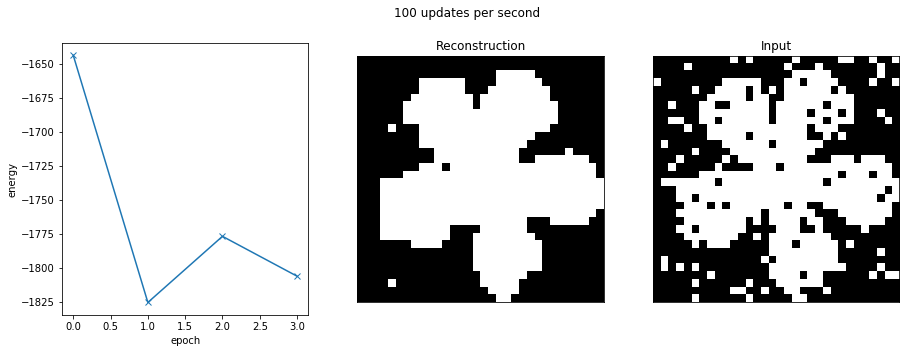

In [243]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

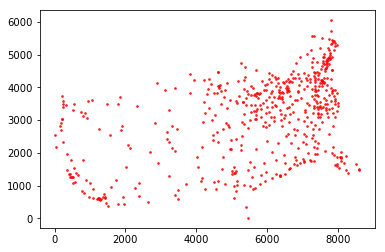

In [19]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [20]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
     
    if route is not None:
        coordinates = coordinates[route]
    
    path_length = len(coordinates)
    dist = 0
    for i in range(path_length-1):
        dist += ((abs(coordinates[i+1,0] - coordinates[i,0]))**2 + (abs(coordinates[i+1,1] - coordinates[i,1]))**2)**(1/2)

    dist += ((coordinates[-1][0] - coordinates[0][0])**2 + (coordinates[-1][1] - coordinates[0][1])**2)**(1/2)
    return dist/1000

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [464]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [22]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [23]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):
        
        for idx in np.random.permutation(N):
            #attempt permutation
            temp_route = route.copy()
            if (idx<N-1):
                succ = idx+1
            else:
                succ = 0 #case for idx=N-1, last element
            
            temp_route[[idx, succ]] = temp_route[[succ, idx]] #swap with successor
            #compute acceptance probability A
            if (distance(coordinates, temp_route) < distance(coordinates, route)):
                route = temp_route.copy()
            else:
                fraction = np.exp((1/T)*(distance(coordinates, route) - distance(coordinates, temp_route)))
                acc_prob = min(1, fraction)
                accept = np.random.binomial(1,acc_prob,1)
                if (accept==1):
                    route = temp_route.copy()
        
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

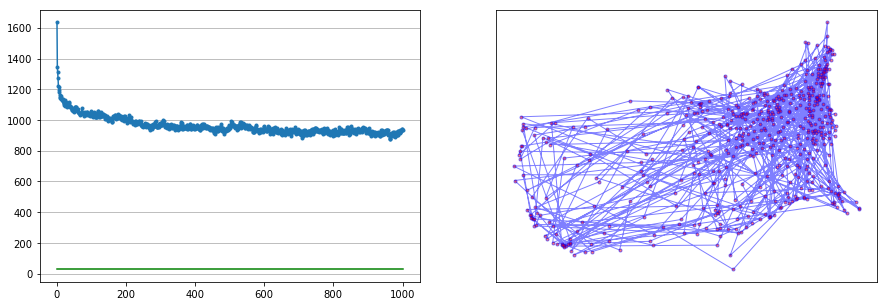

In [240]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [24]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        for idx in np.random.permutation(N):
            #attempt permutation
            temp_route = route.copy()
            if (idx<N-1):
                succ = idx+1
            else:
                succ = 0 #case for idx=N-1, last element
            
            temp_route[[idx, succ]] = temp_route[[succ, idx]] #swap with successor
            #compute acceptance probability A
            if (distance(coordinates, temp_route) < distance(coordinates, route)):
                route = temp_route.copy()
            else:
                fraction = np.exp((1/T)*(distance(coordinates, route) - distance(coordinates, temp_route)))
                acc_prob = min(1, fraction)
                accept = np.random.binomial(1,acc_prob,1)
                if (accept==1):
                    route = temp_route.copy()
        T = eta*T    
        print('T:', T)
                
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

T: 19.9
T: 19.8005
T: 19.7014975
T: 19.602990012499998
T: 19.5049750624375
T: 19.40745018712531
T: 19.31041293618968
T: 19.213860871508732
T: 19.117791567151187
T: 19.022202609315432
T: 18.927091596268856
T: 18.83245613828751
T: 18.738293857596073
T: 18.644602388308094
T: 18.551379376366555
T: 18.45862247948472
T: 18.366329367087296
T: 18.27449772025186
T: 18.1831252316506
T: 18.092209605492346
T: 18.001748557464886
T: 17.91173981467756
T: 17.82218111560417
T: 17.73307021002615
T: 17.644404858976017
T: 17.556182834681138
T: 17.468401920507734
T: 17.381059910905197
T: 17.29415461135067
T: 17.207683838293917
T: 17.121645419102446
T: 17.036037192006933
T: 16.9508570060469
T: 16.866102721016663
T: 16.781772207411578
T: 16.69786334637452
T: 16.614374029642647
T: 16.531302159494434
T: 16.44864564869696
T: 16.366402420453475
T: 16.284570408351208
T: 16.203147556309453
T: 16.122131818527905
T: 16.041521159435266
T: 15.96131355363809
T: 15.8815069858699
T: 15.802099450940549
T: 15.7230889536858

T: 2.8744995451424447
T: 2.8601270474167326
T: 2.845826412179649
T: 2.831597280118751
T: 2.817439293718157
T: 2.8033520972495665
T: 2.7893353367633185
T: 2.7753886600795017
T: 2.761511716779104
T: 2.7477041581952086
T: 2.7339656374042325
T: 2.720295809217211
T: 2.7066943301711253
T: 2.6931608585202698
T: 2.6796950542276683
T: 2.66629657895653
T: 2.652965096061747
T: 2.639700270581438
T: 2.626501769228531
T: 2.613369260382388
T: 2.6003024140804762
T: 2.5873009020100737
T: 2.574364397500023
T: 2.5614925755125233
T: 2.548685112634961
T: 2.535941687071786
T: 2.5232619786364268
T: 2.5106456687432446
T: 2.498092440399528
T: 2.4856019781975305
T: 2.473173968306543
T: 2.4608080984650105
T: 2.4485040579726856
T: 2.4362615376828223
T: 2.424080229994408
T: 2.4119598288444357
T: 2.3999000297002135
T: 2.3879005295517124
T: 2.375961026903954
T: 2.364081221769434
T: 2.352260815660587
T: 2.340499511582284
T: 2.3287970140243726
T: 2.317153028954251
T: 2.3055672638094795
T: 2.294039427490432
T: 2.282569

T: 0.43437386325481253
T: 0.4322019939385385
T: 0.43004098396884577
T: 0.4278907790490015
T: 0.4257513251537565
T: 0.42362256852798774
T: 0.4215044556853478
T: 0.419396933406921
T: 0.4172999487398864
T: 0.41521344899618695
T: 0.413137381751206
T: 0.41107169484245
T: 0.40901633636823775
T: 0.40697125468639656
T: 0.4049363984129646
T: 0.40291171642089973
T: 0.40089715783879526
T: 0.39889267204960127
T: 0.39689820868935327
T: 0.3949137176459065
T: 0.39293914905767696
T: 0.39097445331238856
T: 0.3890195810458266
T: 0.3870744831405975
T: 0.38513911072489454
T: 0.38321341517127006
T: 0.3812973480954137
T: 0.37939086135493666
T: 0.377493907048162
T: 0.37560643751292117
T: 0.37372840532535656
T: 0.3718597632987298
T: 0.3700004644822361
T: 0.36815046215982494
T: 0.36630970984902583
T: 0.3644781612997807
T: 0.3626557704932818
T: 0.3608424916408154
T: 0.35903827918261133
T: 0.3572430877866983
T: 0.3554568723477648
T: 0.35367958798602595
T: 0.35191119004609583
T: 0.35015163409586536
T: 0.348400875

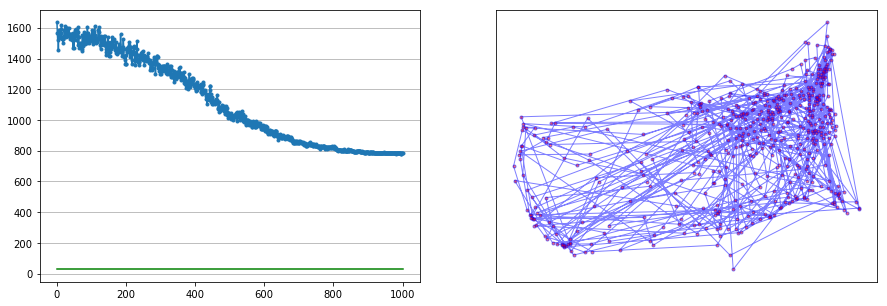

In [238]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [465]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    
    #computing local energy before flip
    N = 4
    #computes sum over neighbours & energy delta of neighbours 
    dE_neighbours = 0
    N_sum = 0
    if (i-1 >= 0): 
        N_sum += estimate[i-1][j]
        dE_neighbours += beta*(estimate[i-1][j]/N)*estimate[i][j]
    if (j-1 >= 0): 
        N_sum += estimate[i][j-1]
        dE_neighbours += beta*(estimate[i][j-1]/N)*estimate[i][j]
    if (i+1 < height): 
        N_sum += estimate[i+1][j]
        dE_neighbours += beta*(estimate[i+1][j]/N)*estimate[i][j]
    if (j+1 < width): 
        N_sum += estimate[i][j+1]
        dE_neighbours += beta*(estimate[i][j+1]/N)*estimate[i][j]
    E1 = (estimate[i][j]/N)*N_sum
    #sum within the second term of the energy E
    E2 = estimate[i][j]*noisy[i][j]  
            
    E_local_before = -(beta/2)*E1 - mu*E2
    #algebraically it can be notices that:
    E_local_after = - E_local_before
    
    dE = E_local_after - E_local_before + dE_neighbours
    
    return dE

def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            i = pix//width
            j = pix%width
            #compare energies before and after flip
            dE = local_energy_change(noisy_img, estimate, i, j, beta, mu)
            
            fraction = np.exp((1/T)*(-dE))
            acc_prob = min(1, fraction)
            accept = np.random.binomial(1,p=acc_prob)
            if (accept==1):
                estimate[i][j] = -estimate[i][j]
            
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

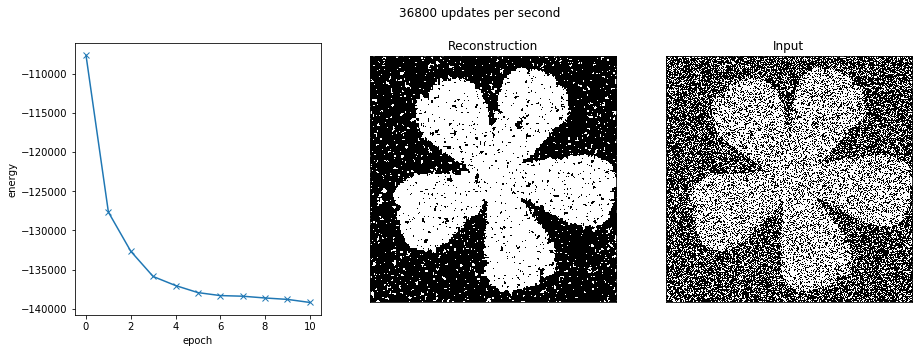

(-139201.0, 0.07365555555555556)

In [466]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [467]:
print(E_metro, E_local)
assert E_metro == E_local

(-1806.0, 0.048828125) (-1806.0, 0.048828125)


<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [468]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    #compute dE for each pixel within the grid and returns array of dEs (same size as grid)
    actual_grid = estimate*grid
    E1_grid = 2*mu*actual_grid*noisy_img
    
    #compute neighnboours term through convolution
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    n_terms = fftconvolve(estimate, kernel, mode="same")*grid #neighbour terms matrix
    n_terms = (beta/2)*actual_grid*n_terms
    
    dEs = E1_grid + n_terms
    return dEs
    

In [469]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    grid1 = np.zeros((estimate.shape[0], estimate.shape[1]))
    grid1[::2,::2] = 1
    grid1[1::2,1::2] = 1
    grid2 = np.ones((estimate.shape[0], estimate.shape[1]))
    grid2[::2,::2] = 0
    grid2[1::2,1::2] = 0
    grids=[]
    grids.append(grid1)
    grids.append(grid2)
    
    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for grid in grids:
                #calls checkerboard_energy_change which returns dEs for each pixel in grid
                dEs = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
                #decides whether to accept or reject flip for each pixel in grid (vectorized operations)
                fractions = np.exp((1/T)*(-dEs))
                accept_probs = np.minimum(1, fractions)
                accept = np.random.binomial(1, accept_probs) #matrix contains 1 if accept
                value_swapper_mask = -accept*grid
                value_swapper_mask[value_swapper_mask == 0] = 1 #leaves unaltered indexes excluded by current grid
                
                estimate = value_swapper_mask*estimate

        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

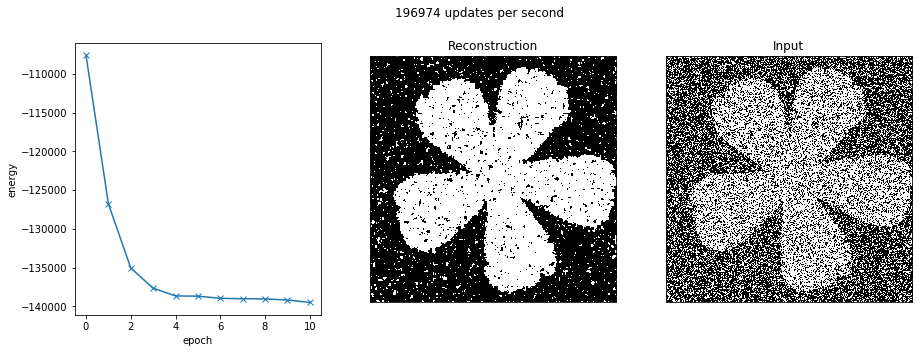

(-139485.5, 0.06881111111111111)

In [470]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)#10 epochs

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

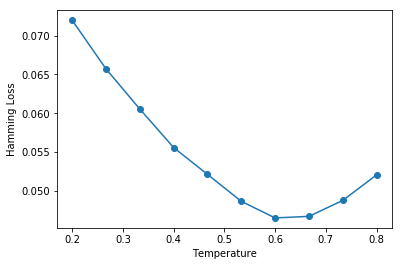

In [389]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

The Hamming Loss measures the fraction of labels(pixels' values) incorrectly predicted. The function evaluate_ising() calls a given method (checkerboard_metropolis in this case) with a fixed number of epochs and temperature parameter T. In this graph we can see how the temperature parameter is linked with a concept usually called under/over-fitting. In particular, low temperature values (e.g., 0.2) make the algorithm get stuck to a local optimum with high probability, as a consequence the final solution has high hamming loss. When the temperature given is increased (e.g., 0.6) the algorithm has a natural trade-off between exploration of the solution space and optimization; as a consequence a rather good solution is found (i.e., the one that minimizes the hamming loss for the given values of T). But if the temperature in increased excessively (e.g., 0.8+), then the algorithm doesn't perceive much structure in the solution space (in particular, the sampling distribution induced by the energy function is excessively uniform over the solution space) and therefore it cannot optimize enough. Virtually, if the temperature would be set to +$\infty$ then the algorithm would not have preference for one solution over another.

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

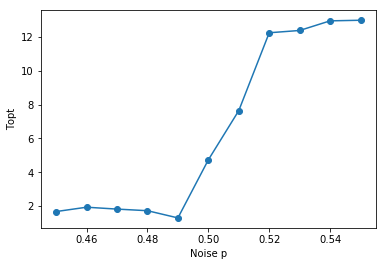

In [451]:
def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

It can be noticed a positive (non monotonic) trend between the level of randomization (Noise p) of the "initial solution" (i.e., the given randomized/noisy image defines the starting point of the algorithm within the solution space) and the optimal temperature parameter. This may be due to the fact that, if the initial configuration is very distant (Hamming distance) from the true one, then the sampling procedure needs to explore the solution space intesively (it has little information regarding which regions of the solution space may contain good solutions) and an higher value of T helps in doing so since it induces a posterior closer to the uniform distribution. On the other hand, if the level of randomization is low, it is more probable that the solution(i.e., the true image) is closer (w.r.t. the Hamming distance) to the initial noisy image. Therefore it is less needed to explore the entire solution space since we have less uncertainty, and this can be achieved by setting T to a lower value (less uniform distribution, more discriminant between regions).

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

In [471]:
def compute_proposal(route, i, N):
    route = route.tolist()
    new_route = []
    if (i<N-1):
        j = np.random.randint(i+1, N, 1).item()
        sublist = route[i:j+1]
        inverted_sublist = sublist[::-1]
        new_route = route[:i] + inverted_sublist + route[j+1:]
    else:
        new_route = route
    return np.array(new_route)

def myfancyalgorithm(coordinates, route=None, epochs=1):
    
    np.random.seed(7)
    
    N = coordinates.shape[0]
    T = 5.0
    eta = 0.95
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        for idx in np.random.permutation(N):
            #attempt permutation
            temp_route = compute_proposal(route.copy(), idx, N)
            
            #compute acceptance probability A
            if (distance(coordinates, temp_route) < distance(coordinates, route)):
                route = temp_route.copy()
            else:
                #q is symmetric hence the Metropolis acceptance rule is sufficient
                fraction = np.exp((1/T)*(distance(coordinates, route) - distance(coordinates, temp_route)))
                acc_prob = min(1, fraction)
                accept = np.random.binomial(1,acc_prob,1)
                if (accept==1):
                    route = temp_route.copy()
        T = eta*T    
        new_distance = distance(coordinates, route)
        distances.append(new_distance)
    
    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

T: 4.75
Finished epoch: 0
distance: 1490.3460739100747
T: 4.5125
Finished epoch: 1
distance: 1435.0585907046413
T: 4.286875
Finished epoch: 2
distance: 1422.1154651484885
T: 4.07253125
Finished epoch: 3
distance: 1407.235708317188
T: 3.8689046874999997
Finished epoch: 4
distance: 1321.5361842836444
T: 3.6754594531249998
Finished epoch: 5
distance: 1321.2102116168326
T: 3.4916864804687497
Finished epoch: 6
distance: 1267.5082863908688
T: 3.317102156445312
Finished epoch: 7
distance: 1249.277090159724
T: 3.151247048623046
Finished epoch: 8
distance: 1231.317142831436
T: 2.993684696191894
Finished epoch: 9
distance: 1215.699013015614
T: 2.844000461382299
Finished epoch: 10
distance: 1181.127286656566
T: 2.701800438313184
Finished epoch: 11
distance: 1165.7556310474242
T: 2.5667104163975245
Finished epoch: 12
distance: 1158.3529292079224
T: 2.438374895577648
Finished epoch: 13
distance: 1158.3704879994827
T: 2.3164561507987655
Finished epoch: 14
distance: 1087.0079403346558
T: 2.2006333432

T: 0.01117066515104294
Finished epoch: 118
distance: 197.9618894707817
T: 0.010612131893490792
Finished epoch: 119
distance: 196.8924510500572
T: 0.010081525298816252
Finished epoch: 120
distance: 195.88229255438293
T: 0.009577449033875439
Finished epoch: 121
distance: 195.14664792229905
T: 0.009098576582181666
Finished epoch: 122
distance: 193.47320876958608
T: 0.008643647753072583
Finished epoch: 123
distance: 193.15869198035946
T: 0.008211465365418953
Finished epoch: 124
distance: 192.7450737857938
T: 0.007800892097148005
Finished epoch: 125
distance: 191.49681854347378
T: 0.007410847492290605
Finished epoch: 126
distance: 190.16276849599382
T: 0.007040305117676074
Finished epoch: 127
distance: 189.05675772970298
T: 0.0066882898617922695
Finished epoch: 128
distance: 187.52119482363423
T: 0.006353875368702655
Finished epoch: 129
distance: 187.2652749558865
T: 0.006036181600267522
Finished epoch: 130
distance: 185.91796972778752
T: 0.005734372520254146
Finished epoch: 131
distance: 1

T: 3.573738954362627e-05
Finished epoch: 230
distance: 134.0470143966187
T: 3.395052006644496e-05
Finished epoch: 231
distance: 133.8732697245248
T: 3.2252994063122706e-05
Finished epoch: 232
distance: 133.6821384067603
T: 3.064034435996657e-05
Finished epoch: 233
distance: 131.7376967639758
T: 2.9108327141968242e-05
Finished epoch: 234
distance: 131.72675665792593
T: 2.7652910784869828e-05
Finished epoch: 235
distance: 131.5932480028252
T: 2.6270265245626333e-05
Finished epoch: 236
distance: 131.5932480028252
T: 2.4956751983345015e-05
Finished epoch: 237
distance: 131.34801757844346
T: 2.3708914384177764e-05
Finished epoch: 238
distance: 131.34801757844346
T: 2.2523468664968875e-05
Finished epoch: 239
distance: 131.34801757844346
T: 2.139729523172043e-05
Finished epoch: 240
distance: 131.1711408804579
T: 2.032743047013441e-05
Finished epoch: 241
distance: 130.70227632148732
T: 1.9311058946627688e-05
Finished epoch: 242
distance: 129.73847617386986
T: 1.8345505999296304e-05
Finished ep

T: 1.203491460727383e-07
Finished epoch: 341
distance: 112.94559543676031
T: 1.1433168876910139e-07
Finished epoch: 342
distance: 112.94559543676031
T: 1.0861510433064632e-07
Finished epoch: 343
distance: 112.45034109805252
T: 1.03184349114114e-07
Finished epoch: 344
distance: 112.45034109805252
T: 9.80251316584083e-08
Finished epoch: 345
distance: 111.54006756264583
T: 9.312387507548787e-08
Finished epoch: 346
distance: 111.54006756264583
T: 8.846768132171348e-08
Finished epoch: 347
distance: 111.42303681928288
T: 8.404429725562781e-08
Finished epoch: 348
distance: 111.24052743078043
T: 7.984208239284642e-08
Finished epoch: 349
distance: 111.24052743078043
T: 7.584997827320409e-08
Finished epoch: 350
distance: 111.24052743078043
T: 7.205747935954389e-08
Finished epoch: 351
distance: 111.12612123349115
T: 6.845460539156669e-08
Finished epoch: 352
distance: 111.12612123349115
T: 6.503187512198835e-08
Finished epoch: 353
distance: 110.92369350562029
T: 6.178028136588893e-08
Finished epoc

T: 4.0528749148720404e-10
Finished epoch: 452
distance: 105.93981448115845
T: 3.8502311691284384e-10
Finished epoch: 453
distance: 105.93981448115845
T: 3.6577196106720166e-10
Finished epoch: 454
distance: 105.92385450957701
T: 3.4748336301384156e-10
Finished epoch: 455
distance: 105.83339682660848
T: 3.3010919486314947e-10
Finished epoch: 456
distance: 105.83339682660848
T: 3.13603735119992e-10
Finished epoch: 457
distance: 105.63265368012847
T: 2.9792354836399235e-10
Finished epoch: 458
distance: 105.63265368012847
T: 2.830273709457927e-10
Finished epoch: 459
distance: 105.61927327331334
T: 2.6887600239850306e-10
Finished epoch: 460
distance: 105.61927327331334
T: 2.554322022785779e-10
Finished epoch: 461
distance: 105.61927327331334
T: 2.42660592164649e-10
Finished epoch: 462
distance: 105.61927327331334
T: 2.3052756255641654e-10
Finished epoch: 463
distance: 105.15504431369976
T: 2.190011844285957e-10
Finished epoch: 464
distance: 105.15504431369976
T: 2.080511252071659e-10
Finishe

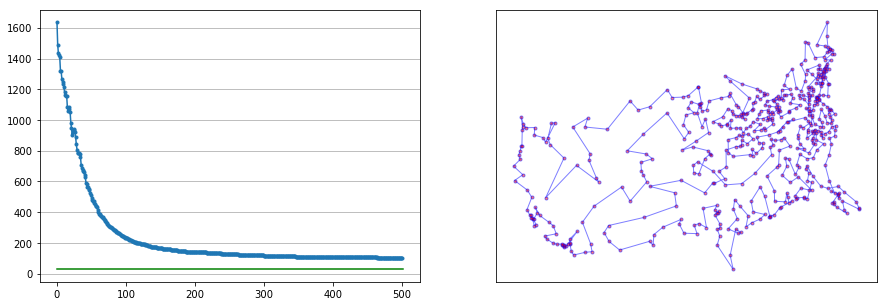

In [384]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.